### GAN

GAN이란 상대적 적대 신경망으로서 Generative Adversarial Network이다.  
- Generative(생성적): 데이터 자체를 생성한다.
- Adversarial(적대적): 적대란 대립하거나 상반되는 관계를 뜻한다. GAN에서는 생성네트워크와 구분 네트워크간의 상반되는 목적함수로 인해 적대성이 생기게 된다.
- Network: 생성자와 구분자의 구조가 인공 신경망의 형태를 이룬다.

자세한 내용은 앞선 Post <a href="https://wjddyd66.github.io/pytorch/2019/10/07/Pytorch-GAN.html">Pytorch-GAN</a>을 참조  

이번 Post에서는 Tensorflow로서 같은 작업을 해보며 성능 비교 및 결과를 확인하는 것을 목표로 한다.

### GAN 구현

#### 필요한 라이브러리 임포트

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

#### MNIST Dataset & Plot
MNIST데이터를 다운받고, 생성된 MNIST 이미지를 8x8 그리드 형태로 그려주는 plot 함수 정의  
matplotlib.gridspec.GridSpec 사용  
<a href="https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.gridspec.GridSpec.html">정식 사이트 사용 방법</a>  
이번 코드에서 사용한 방법을 알아보면  
- parameter: 1 x (28x28)형태로 들어옴: samples
- figsize = (8,8): 최종적인 보여주는 suplot의 형태를 8 x 8로 지정
- plt.imshow(samples.reshape(28,28)): 1 x (28x28)형태를 image로 보기위하여 원본 image의 크기로 변환

gridspec로서 사용한 Parameter중 사용한 Parameter만 알아본다.  
추가적인 자세한 Parameter는 위의 정식 사이트 이용방법에서 참조  

**matplotlib.gridspec.GridSpec Parameter**  
<table class="table">

<tr>
	<td>Parameter</td>
	<td>설명</td>
</tr>

<tr>
	<td>nrows</td>
	<td>Number of rows in grid</td>
</tr>

<tr>
	<td>ncols</td>
	<td>Number of columns in grid</td>
</tr>
<tr>
	<td>wsapce</td>
	<td>The amount of width reserved for space between subplots</td>
</tr>
<tr>
	<td>hspace</td>
	<td>The amount of height reserved for space between subplots</td>
</tr>
</table>
<br>

In [2]:
# MNIST 데이터를 다운로드하고 불러옵니다.
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# 생성된 MNIST 이미지를 8x8 Grid로 보여주는 plot 함수를 정의합니다.
def plot(samples):
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(8, 8)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        plt.imshow(sample.reshape(28, 28))

    return fig

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from t

#### 하이퍼 파라미터 설정
- num_epoch: 반복 횟수
- batch_size: 경사하강법의 한 스템에서 사용할 배치 개수
- num_input: 입력층의 Input size
- num_latenet_variable: z의 크기이다. 즉 생성할 Noise의 차원
- num_hidden: Hidden Size크기
- learning_rate: Learning Rate

In [3]:
num_epoch = 100000
batch_size = 64
num_input = 28 * 28
num_latent_variable = 100   # 잠재 변수 z의 차원
num_hidden = 128
learning_rate = 0.001

#### PlaceHolder 설정
사용할 진짜 이미지 x 와 임의로 생성할 이미지 z(Noise)를 입력받을 변수 설정

In [4]:
X = tf.placeholder(tf.float32, shape=[None, num_input])
z = tf.placeholder(tf.float32, shape=[None, num_latent_variable])

#### 생성자, 구분자 변수 선언
생성자(Generator)와 구분자(Discriminator)에 대한 변수를 각각 설정한다.  

**생성자(Generator)**  
num_latenent_variable -> num_hidden -> num_input으로서 최종적인 크기는 Input Size와 동일한 크기를 가지도록 한다.  

**구분자(Discriminator)**  
num_input -> num_hidden -> 1으로서 최종적인 크기는 1의 크기를 가지게 한다.

**tf.variable_scope**  
변수를 공유하기 위해서 사용하는 방식이다.  
예시는 아래와 같다.  
```python
def my_image_filter(input_images):
    conv1_weights = tf.Variable(tf.random_normal([5, 5, 32, 32]),
        name="conv1_weights")
    conv1_biases = tf.Variable(tf.zeros([32]), name="conv1_biases")
    conv1 = tf.nn.conv2d(input_images, conv1_weights,
        strides=[1, 1, 1, 1], padding='SAME')
    relu1 = tf.nn.relu(conv1 + conv1_biases)

    conv2_weights = tf.Variable(tf.random_normal([5, 5, 32, 32]),
        name="conv2_weights")
    conv2_biases = tf.Variable(tf.zeros([32]), name="conv2_biases")
    conv2 = tf.nn.conv2d(relu1, conv2_weights,
        strides=[1, 1, 1, 1], padding='SAME')
    return tf.nn.relu(conv2 + conv2_biases)
```
여러분이 쉽게 상상할 수 있듯이, 모델은 이것보다 훨씬 더 복잡하며, 여기에도 이미 4개의 다른 변수가 있습니다: conv1_weights, conv1_biases, conv2_weights, 그리고 conv2_biases.
문제는 이 모델을 다시 사용하고자 할 때 발생합니다. 2개의 다른 이미지, image1과 image2를 여러분의 이미지 필터에 적용하기를 원한다고 가정하십시오. 여러분은 같은 파라미터로 같은 필터에서 처리된 이미지가 필요합니다. my_image_filter()를 두 번 호출할 수 있지만, 이것은 두 세트의 변수를 생성합니다 :
#### First call creates one set of variables.
result1 = my_image_filter(image1)
#### Another set is created in the second call.
result2 = my_image_filter(image2)

즉 지속적인 변수 생성을 막아 메모리를 효율적으로 사용하고 변수의 범위를 지정해줄 수 있는 Tensorflow의 기능이라고 생각하면 된다.  

자세한 사항은 아래 링크 참조  
<a href="https://tensorflowkorea.gitbooks.io/tensorflow-kr/content/g3doc/how_tos/variable_scope/">tensorflowkorea 사용 예시</a>

In [6]:
with tf.variable_scope('generator'):
    # 히든 레이어 파라미터 
    G_W1 = tf.Variable(tf.random_normal(shape=[num_latent_variable, num_hidden], stddev=5e-2))   
    G_b1 = tf.Variable(tf.constant(0.1, shape=[num_hidden]))
    # 아웃풋 레이어 파라미터
    G_W2 = tf.Variable(tf.random_normal(shape=[num_hidden, num_input], stddev=5e-2))   
    G_b2 = tf.Variable(tf.constant(0.1, shape=[num_input]))

with tf.variable_scope('discriminator'):
    # 히든 레이어 파라미터
    D_W1 = tf.Variable(tf.random_normal(shape=[num_input, num_hidden], stddev=5e-2))   
    D_b1 = tf.Variable(tf.constant(0.1, shape=[num_hidden]))
    # 아웃풋 레이어 파라미터
    D_W2 = tf.Variable(tf.random_normal(shape=[num_hidden, 1], stddev=5e-2))   
    D_b2 = tf.Variable(tf.constant(0.1, shape=[1]))

#### 생성자, 구분자 생성
위에서 **tf.variable_scope**에서 선언한 Parameter를 활용하여 실제 Generator와 discriminator를 선언한다.  
각각의 Hidden Layer는 1개 뿐이며 단순한 matmul과 sigmoid를 통하여 이루워 진다.  

In [7]:
# Generator를 생성하는 함수를 정의합니다.
# Inputs:
#   X : 인풋 Latent Variable
# Outputs:
#   generated_mnist_image : 생성된 MNIST 이미지
def build_generator(X):
    hidden_layer = tf.nn.relu((tf.matmul(X, G_W1) + G_b1))
    output_layer = tf.matmul(hidden_layer, G_W2) + G_b2
    generated_mnist_image = tf.nn.sigmoid(output_layer)

    return generated_mnist_image

# Discriminator를 생성하는 함수를 정의합니다.
# Inputs:
#   X : 인풋 이미지
# Outputs:
#   predicted_value : Discriminator가 판단한 True(1) or Fake(0)
#   logits : sigmoid를 씌우기전의 출력값
def build_discriminator(X):
    hidden_layer = tf.nn.relu((tf.matmul(X, D_W1) + D_b1))
    logits = tf.matmul(hidden_layer, D_W2) + D_b2
    predicted_value = tf.nn.sigmoid(logits)

    return predicted_value, logits

#### D,G 생성
GAN설명에서의 D,G를 정의하는 과정이다.  
- D(x): Data를 실제 데이터는 1, 생성 데이터는 0으로 판별하는 함수
- G(x): Data를 생성하는 함수
- x: 실제 데이터
- z: Noise

위의 최종적인 결과로서  
실제 Data를 분별한 값: D_real, D_real_logits 와  
생성한 Data(G(z))를 분별한 값: D_fake, D_fake_logits가 생성된다.

In [8]:
# 생성자(Generator)를 선언합니다.
G = build_generator(z)

# 구분자(Discriminator)를 선언합니다.
D_real, D_real_logits = build_discriminator(X)  # D(x)
D_fake, D_fake_logits = build_discriminator(G)  # D(G(z))

### LossFunction 정의

<p>$$ \underset{G}{min} \underset{D}{max}V(D,G) = \mathbb{E}_{x\text{~}P_{data}(x)}[logD(x)] + \mathbb{E}_{z\text{~}P_{z}(z)}[log(1 - D(G(z)))]$$</p>
<p>$$\mathbb{E}: \text{기대값}$$</p>
<p>$$x\text{~}P_{data}(x): \text{x를 실제 data의 분포에서 샘플링}$$</p>
<p>$$z\text{~}P_{z}(z): \text{z를 Noise의 분포에서 샘플링}$$</p>

**구분자**  
<p>$$ \underset{D}{max}V(D,G) = \mathbb{E}_{x\text{~}P_{data}(x)}[logD(x)] + \mathbb{E}_{z\text{~}P_{z}(z)}[log(1 - D(G(z)))]$$</p>

**생성자**  
<p>$$ \underset{G}{min}V(D,G) = \mathbb{E}_{x\text{~}P_{data}(x)}[logD(x)] + \mathbb{E}_{z\text{~}P_{z}(z)}[log(1 - D(G(z)))]$$</p>
<p>$$=> Trainning의 시간을 줄이기 위하여 식 변경$$</p>
<p>$$ \underset{G}{max}V(D,G) = \mathbb{E}_{z\text{~}P_{z}(z)}[log( D(G(z)))]$$</p>

log 함수를 적용하기 위하여 **tf.nn.sigmoid_cross_entropy_with_logits** 사용  

**tf.nn.sigmoid_cross_entropy_with_logits**  
<code>tf.nn.sigmoid_cross_entropy_with_logits(
    labels=None,
    logits=None,
    name=None
)</code><br>
> **x = logits, z = labels**
tf.nn.sigmoid_cross_entropy_with_logits(logits = x, labels =z)
= z * -log(sigmoid(x)) + (1-z) * -log(1 - sigmoid(x))

<a href="https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits">TensorFlow 정식 홈페이지 사용방법</a><br>

위의 식을 아래에 적용 시켜보자  
```python
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones_like(D_real_logits)))
```
위의 코드를 식으로서 표현하게 된다면  
<p>$$d_loss_real = mean(1 * -log(sigmoid(\text{D_real_logits}) + (1-1) * -log(1-sigmoid(\text{D_real_logits}))))$$</p>
<p>$$= mean(-log(sigmoid(\text{D_real_logits})))$$</p>
<p>$$= mean(-log(\frac{1}{1+e^{-\text{D_real_logits}}}))$$</p>
<p>$$= mean(log(1+e^{-\text{D_real_logits}}))$$</p>

최종적인 위의 식에서 간단하게 식을 <span>$log(1+e^{-x})$</span>라고 생각하고 그래프를 그려보면 다음과 같다.  
<img src="https://raw.githubusercontent.com/wjddyd66/wjddyd66.github.io/master/static/img/AI/150.PNG" height="100%" width="100%" />

위에서 tf.variable_scope로서 변수 선언을 할 때 분산값을 작게 주어서 대부분의 값은 0의 가깝게 위치하게 되고 bias를 통하여 +0.1을 하여도 그래프의 값은 0.5 이하일 것을 예측할 수 있다.  
(Gradient Vanishing이나 Gradient exploding현상이 일어나지 않을 것 이다.)

In [9]:
# Discriminator의 손실 함수를 정의합니다.
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones_like(D_real_logits)))    # log(D(x))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros_like(D_fake_logits)))   # log(1-D(G(z)))
d_loss = d_loss_real + d_loss_fake  # log(D(x)) + log(1-D(G(z)))

# Generator의 손실 함수를 정의합니다.
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones_like(D_fake_logits)))         # log(D(G(z))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### 각각의 Parameter들을 List로 통합
<a href="https://tensorflowkorea.gitbooks.io/tensorflow-kr/content/g3doc/api_docs/python/state_ops.html">Tensorflow tf.trainable_variable() 사용법</a>의 사이트를 찾아가면 **tf.trainable_variables()** 는 다음과 같다.  
> Returns all variables created with trainable = True<br>
Returns: A list of Variable objects

위의 코드를 활용하여 각각의 Trainning가능한 Parameter들을 Discriminator와 Generator에 관련된 파라미터로서 모았다.

In [10]:
tvar = tf.trainable_variables()
dvar = [var for var in tvar if 'discriminator' in var.name]
gvar = [var for var in tvar if 'generator' in var.name]

#### Optimizer
Discriminator와 Generator를 구별하여 각각의 Netowrk에 관련된 Parameter들을 따로 분리하여 Optimier하는 방식이다.  
Optimizer는 Adam을 사용하였다.

In [11]:
d_train_step = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=dvar)
g_train_step = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=gvar)

#### 학습 결과 저장 폴터 지정
학습 결과로 생성된 이미지를 지정할 폴더 설정

In [12]:
# 생성된 이미지들을 저장할 generated_output 폴더를 생성합니다.
num_img = 0
if not os.path.exists('generated_output/'):
    os.makedirs('generated_output/')

#### Trainning 및  결과 확인
정의된 Parameter, LossFunction, Optimizer를 통하여 Trainning한다.  
매 Epoch마다 HyperParameter를 Update한다.  
500 Epoch마다 생성된 Image를 저장한다.  
**Image는 위에서 8 x 8 개수로서 Plot하기로 하였으므로 Image를 생성하는 BatchSize는 64로서 고정한다.**  

**np.random.uniform(-1., 1., [batch_size, 100])**  
<code>numpy.random.uniform(low=0.0, high=1.0, size=None)</code><br>
>Draw samples from a uniform distribution

<a href="https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.uniform.html">scipy 사용법</a><br>

In [15]:
# 그래프를 실행합니다.
with tf.Session() as sess:
    # 변수들에 초기값을 할당합니다.
    sess.run(tf.global_variables_initializer())
    
    # num_epoch 횟수만큼 최적화를 수행합니다.
    for i in range(num_epoch):
        # MNIST 이미지를 batch_size만큼 불러옵니다. 
        batch_X, _ = mnist.train.next_batch(batch_size)
        # Latent Variable의 인풋으로 사용할 noise를 Uniform Distribution에서 batch_size 개수만큼 샘플링합니다.
        batch_noise = np.random.uniform(-1., 1., [batch_size, 100])
        
        # 500번 반복할때마다 생성된 이미지를 저장합니다.
        if i % 500 == 0:
            samples = sess.run(G, feed_dict={z: np.random.uniform(-1., 1., [64, 100])})
            fig = plot(samples)
            plt.savefig('generated_output/%s.png' % str(num_img).zfill(3), bbox_inches='tight')
            num_img += 1
            plt.close(fig)
    
        # Discriminator 최적화를 수행하고 Discriminator의 손실함수를 return합니다.
        _, d_loss_print = sess.run([d_train_step, d_loss], feed_dict={X: batch_X, z: batch_noise})

        # Generator 최적화를 수행하고 Generator 손실함수를 return합니다.
        _, g_loss_print = sess.run([g_train_step, g_loss], feed_dict={z: batch_noise})

        # 100번 반복할때마다 Discriminator의 손실함수와 Generator 손실함수를 출력합니다.
        if i % 5000 == 0:
            print('반복(Epoch): %d, Generator 손실함수(g_loss): %f, Discriminator 손실함수(d_loss): %f' % (i, g_loss_print, d_loss_print))

반복(Epoch): 0, Generator 손실함수(g_loss): 1.462668, Discriminator 손실함수(d_loss): 1.422923
반복(Epoch): 5000, Generator 손실함수(g_loss): 5.218184, Discriminator 손실함수(d_loss): 0.094545
반복(Epoch): 10000, Generator 손실함수(g_loss): 2.824790, Discriminator 손실함수(d_loss): 0.441669
반복(Epoch): 15000, Generator 손실함수(g_loss): 2.023012, Discriminator 손실함수(d_loss): 0.641350
반복(Epoch): 20000, Generator 손실함수(g_loss): 1.833526, Discriminator 손실함수(d_loss): 0.775766
반복(Epoch): 25000, Generator 손실함수(g_loss): 1.967042, Discriminator 손실함수(d_loss): 0.814886
반복(Epoch): 30000, Generator 손실함수(g_loss): 2.018043, Discriminator 손실함수(d_loss): 0.756361
반복(Epoch): 35000, Generator 손실함수(g_loss): 2.237893, Discriminator 손실함수(d_loss): 0.712540
반복(Epoch): 40000, Generator 손실함수(g_loss): 2.088825, Discriminator 손실함수(d_loss): 0.994334
반복(Epoch): 45000, Generator 손실함수(g_loss): 2.640199, Discriminator 손실함수(d_loss): 0.581352
반복(Epoch): 50000, Generator 손실함수(g_loss): 2.181381, Discriminator 손실함수(d_loss): 0.616428
반복(Epoch): 55000, Generato

#### 결과 확인

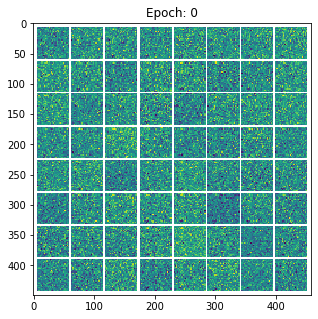

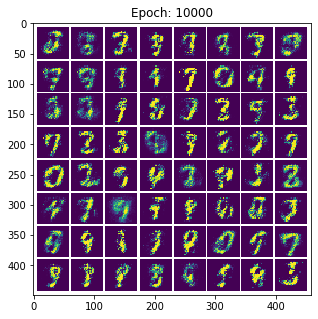

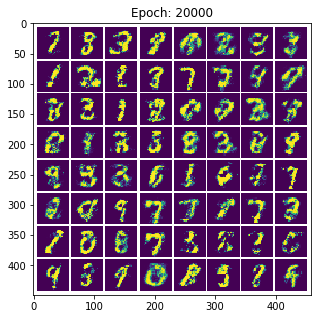

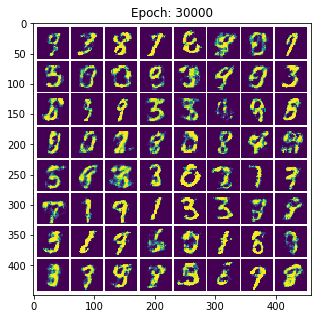

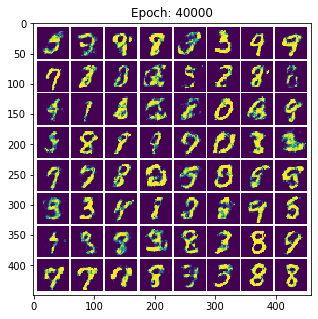

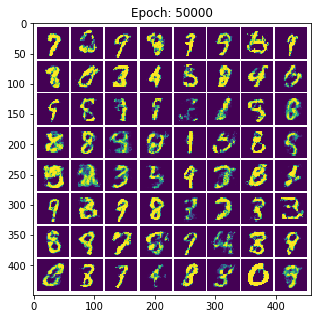

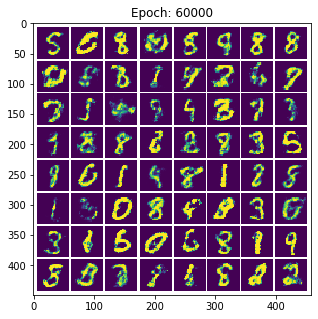

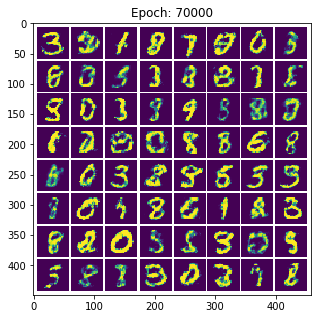

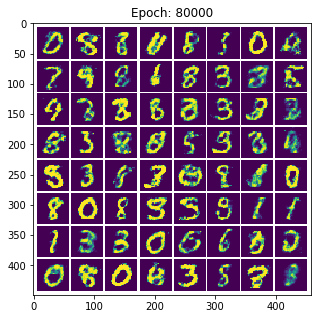

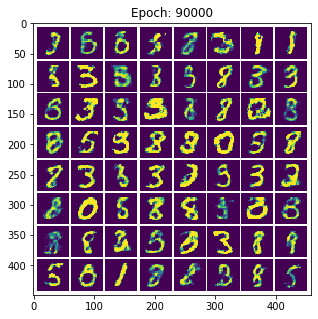

In [32]:
from matplotlib.image import imread
path = './generated_output/'

for i in range(10):
    image_name = i * 20
    image_title = i * 20 * 500
    
    if image_name == 0:
        image_name = '00'+str(image_name)
    elif image_name < 100:
        image_name = '0'+str(image_name)
    else:
        image_name = str(image_name)
    
    image_name = path + image_name + '.png'
    image = imread(image_name)
    plt.figure(figsize=(5,5))
    plt.title('Epoch: '+str(image_title))
    plt.imshow(image)
    plt.show()